In [1]:
#!/usr/bin/env python
# coding: utf-8

# In[2]:
from sklearn import preprocessing
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
import numpy as np
import os
import sys
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn import metrics
import itertools
#import other python scripts for further anlaysis
import reshape
import plotFW
import results
# Initialization of directory information:
thisDir = os.path.expanduser('~/Desktop/MSC_Alexis/analysis/')
dataDir = thisDir + 'data/mvpa_data/'
outDir = thisDir + 'output/subNetsFP/'
# Subjects and tasks
taskList=['mixed', 'motor','mem']
subList=['MSC01','MSC02','MSC03','MSC04','MSC05','MSC06','MSC07','MSC10']
#subList=['MSC01','MSC02','MSC04','MSC05','MSC10']
#all possible combinations of subs and tasks
subsComb=(list(itertools.permutations(subList, 2)))
tasksComb=(list(itertools.permutations(taskList, 2)))
#DS combination
DSvars=list(itertools.product(list(subsComb),list(taskList)))
##SS combination
SSvars=list(itertools.product(list(subList),list(tasksComb)))
#BS combination
BSvars=list(itertools.product(list(subsComb),list(tasksComb)))


""" run_prediction initializes what type of analysis you would like to do
and what classifier you would like to use. For now classifier options are svm:linear svm, logreg: logistic
regression, and ridge:ridge regression. Analysis is the type of analysis you wanted
to run. DS--different subject same task; SS--same subject different task;
BS--different subject different task. Each analysis will concatenate across
subjects and make a dataframe. If FW is true will collect all necessary feature weights and plot or save then
into the appropriate format. """
def run_prediction(classifier, analysis):
    if analysis=='CV':
        classifyCV(classifier, analysis)
    elif analysis=='DS':
        classifyDS(classifier, analysis)
    elif analysis=='SS':
        classifySS(classifier, analysis)
    elif analysis=='BS':
        classifyBS(classifier, analysis)
    else:
        print('did not specify analysis')
def classifyDS(classifier, analysis):
    acc_scores_per_task=[]
    tmp_df=pd.DataFrame(DSvars, columns=['sub','task'])
    dfDS=pd.DataFrame()
    dfDS[['train_sub','test_sub']]=pd.DataFrame(tmp_df['sub'].tolist())
    dfDS['task']=tmp_df['task']
    for index, row in dfDS.iterrows():
        score=model(classifier, analysis, train_sub=row['train_sub'], test_sub=row['test_sub'], train_task=row['task'], test_task=row['task'])
        acc_scores_per_task.append(score)
    dfDS['acc']=acc_scores_per_task
    results.plotACC(dfDS, classifier, analysis)
    results.statsACC(dfDS, classifier, analysis)
    results.boxACC(dfDS, classifier, analysis)
    dfDS.to_csv(outDir+'results/'+classifier+'/acc/'+analysis+'/acc.csv', index=False)
def classifySS(classifier,analysis):
    acc_scores_per_task=[]
    tmp_df=pd.DataFrame(SSvars, columns=['sub','task'])
    dfSS=pd.DataFrame()
    dfSS[['train_task','test_task']]=pd.DataFrame(tmp_df['task'].tolist())
    dfSS['sub']=tmp_df['sub']
    for index, row in dfSS.iterrows():
        score=model(classifier, analysis, train_sub=row['sub'], test_sub=row['sub'], train_task=row['train_task'], test_task=row['test_task'])
        acc_scores_per_task.append(score)
    dfSS['acc']=acc_scores_per_task
    results.plotACC(dfSS, classifier, analysis)
    results.statsACC(dfSS, classifier, analysis)
    results.boxACC(dfSS, classifier, analysis)
    #save accuracy
    dfSS.to_csv(outDir+'results/'+classifier+'/acc/'+analysis+'/acc.csv', index=False)
def classifyBS(classifier, analysis):
    acc_scores_per_task=[]
    tmp_df=pd.DataFrame(BSvars, columns=['sub','task'])
    dfBS=pd.DataFrame()
    dfBS[['train_task','test_task']]=pd.DataFrame(tmp_df['task'].tolist())
    dfBS[['train_sub', 'test_sub']]=pd.DataFrame(tmp_df['sub'].tolist())
    for index, row in dfBS.iterrows():
        score=model(classifier, analysis, train_sub=row['train_sub'], test_sub=row['test_sub'], train_task=row['train_task'], test_task=row['test_task'])
        acc_scores_per_task.append(score)
    dfBS['acc']=acc_scores_per_task
    results.plotACC(dfBS, classifier, analysis)
    results.statsACC(dfBS, classifier, analysis)
    results.boxACC(dfBS, classifier, analysis)
    #save accuracy
    dfBS.to_csv(outDir+'results/'+classifier+'/acc/'+analysis+'/acc.csv', index=False)


def model(classifier, analysis, train_sub, test_sub, train_task, test_task):
    if classifier=='SVC':
        clf=LinearSVC(max_iter=10000, dual=False)
    elif classifier=='logReg':
        clf=LogisticRegression(solver = 'lbfgs', max_iter=10000)
    elif classifier=='ridge':
        clf=RidgeClassifier(max_iter=10000)
    else:
        print('Error: You didnt specify what classifier')
    taskFC=reshape.subNets(dataDir+train_task+'/'+train_sub+'_parcel_corrmat.mat', 'fp')
    restFC=reshape.subNets(dataDir+'rest/'+train_sub+'_parcel_corrmat.mat', 'fp')
    #if your subs are the same
    if train_sub==test_sub:
        test_taskFC=reshape.subNets(dataDir+test_task+'/'+test_sub+'_parcel_corrmat.mat','fp')
        ACCscores=CV_folds(clf, analysis, taskFC, restFC, test_taskFC, restFC)
    else:
        test_taskFC=reshape.subNets(dataDir+test_task+'/'+test_sub+'_parcel_corrmat.mat','fp')
        test_restFC=reshape.subNets(dataDir+'rest/'+test_sub+'_parcel_corrmat.mat','fp')
        ACCscores=CV_folds(clf, analysis, taskFC, restFC, test_taskFC, test_restFC)
    return ACCscores
#Calculate acc of cross validation within sub within task
def classifyCV(classifier, analysis):
    avg_CV=[]
    if classifier=='SVC':
        clf=LinearSVC(max_iter=10000, dual=False)
    elif classifier=='logReg':
        clf=LogisticRegression(solver = 'lbfgs', max_iter=10000)
    elif classifier=='ridge':
        clf=RidgeClassifier(max_iter=10000)
    else:
        print('invalid classifier')
    for task in taskList:
        acc_scores_per_task=[]
        cvTable=[]
        for sub in subList:
            taskFC=reshape.subNets(dataDir+task+'/'+sub+'_parcel_corrmat.mat','fp')
            restFC=reshape.subNets(dataDir+'rest/'+sub+'_parcel_corrmat.mat','fp')
            folds=taskFC.shape[0]
            x_train, y_train=reshape.concateFC(taskFC, restFC)
            CVscores=cross_val_score(clf, x_train, y_train, cv=folds)
            mu=CVscores.mean()
            acc_scores_per_task.append(mu)
            cv_tmp_df=pd.DataFrame({sub:CVscores})
            cvTable.append(cv_tmp_df)
    #acc per fold per sub
        tmp_df=pd.DataFrame({'sub':subList, task:acc_scores_per_task}).set_index('sub')
        avg_CV.append(tmp_df)
        cvTable=pd.concat(cvTable, axis=1)
    #saving cv per folds if debugging
        cvTable.to_csv(outDir+'results/'+classifier+'/acc/'+analysis+'/cvTable_folds.csv', index=False)
    #average acc per sub per tasks
    df=pd.concat(avg_CV, axis=1)
    results.plotACC(df, classifier, analysis)
    results.statsACC(df, classifier, analysis)
    results.boxACC(df, classifier, analysis)
    df.to_csv(outDir+'results/'+classifier+'/acc/'+analysis+'/acc.csv')

def CV_folds(clf, analysis, taskFC, restFC, test_taskFC, test_restFC):
    loo = LeaveOneOut()
    taskSize=taskFC.shape[0]
    restSize=restFC.shape[0]
    t = np.ones(taskSize, dtype = int)
    r=np.zeros(restSize, dtype=int)
    
    if analysis=='SS':
        df=pd.DataFrame()
        acc_score=[]
        for train_index, test_index in loo.split(taskFC):
            Xtrain_rest, Xtest_rest=restFC[train_index], restFC[test_index]
            Xtrain_task=taskFC[train_index]
            ytrain_rest=r[train_index]
            ytrain_task=t[train_index]
            X_tr=np.concatenate((Xtrain_task, Xtrain_rest))
            y_tr = np.concatenate((ytrain_task,ytrain_rest))
            #implementing standardization
            scaler = preprocessing.StandardScaler().fit(X_tr)
            scaler.transform(X_tr)
            clf.fit(X_tr,y_tr)
            tmpdf=pd.DataFrame()
            acc_scores_per_fold=[]
            for t_index, te_index in loo.split(test_taskFC):
                Xtest_task=test_taskFC[te_index]
                X_Test = np.concatenate((Xtest_task, Xtest_rest))
                y_Test = np.array([1, 0])
                #test set
                #standardization
                scaler.transform(X_Test)
                clf.predict(X_Test)
                #Get accuracy of model
                ACCscores=clf.score(X_Test,y_Test)
                acc_scores_per_fold.append(ACCscores)
            tmpdf['inner_fold']=acc_scores_per_fold
            score=tmpdf['inner_fold'].mean()
            acc_score.append(score)
        df['outer_fold']=acc_score
        total_score=df['outer_fold'].mean()
    else:
        df=pd.DataFrame()
        acc_score=[]
        #fold each training set
        for train_index, test_index in loo.split(taskFC):
            Xtrain_rest=restFC[train_index]
            Xtrain_task=taskFC[train_index]
            ytrain_rest=r[train_index]
            ytrain_task=t[train_index]
            X_tr=np.concatenate((Xtrain_task, Xtrain_rest))
            y_tr = np.concatenate((ytrain_task,ytrain_rest))
            #implement standardization
            scaler = preprocessing.StandardScaler().fit(X_tr)
            scaler.transform(X_tr)
            clf.fit(X_tr,y_tr)
            tmpdf=pd.DataFrame()
            acc_scores_per_fold=[]
            #fold each testing set
            for t_index, te_index in loo.split(test_taskFC):
                Xtest_rest=test_restFC[te_index]
                Xtest_task=test_taskFC[te_index]
                X_te=np.concatenate((Xtest_task, Xtest_rest))
                y_te=np.array([1, 0])
                #test set
                #standardization
                scaler.transform(X_te)
                clf.predict(X_te)
                #Get accuracy of model
                ACCscores=clf.score(X_te,y_te)
                acc_scores_per_fold.append(ACCscores)
            tmpdf['inner_fold']=acc_scores_per_fold
            score=tmpdf['inner_fold'].mean()
            acc_score.append(score)
        df['outer_fold']=acc_score
        total_score=df['outer_fold'].mean()

    return total_score


Now running SVC with analysis type DS
subject by subject heatmap


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


diff sub stats
Now running SVC with analysis type SS
task by subject heatmap


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


same sub stats
same sub boxplots
Now running SVC with analysis type BS
subject by subject per train task split heatmap


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


diff sub diff task stats
diff sub diff task boxplots
Now running SVC with analysis type CV
task by subject heatmap
cross validation stats
cross validation boxplots
Now running logReg with analysis type DS
subject by subject heatmap


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


diff sub stats
Now running logReg with analysis type SS


/Users/Alexis/Desktop/MSC_Alexis/analysis/code/mL_rsfMRI/results.py:48: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(8,6))


task by subject heatmap


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/Alexis/Desktop/MSC_Alexis/analysis/code/mL_rsfMRI/results.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


same sub stats
same sub boxplots


/Users/Alexis/Desktop/MSC_Alexis/analysis/code/mL_rsfMRI/results.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(8,6))


Now running logReg with analysis type BS
subject by subject per train task split heatmap


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/Alexis/Desktop/MSC_Alexis/analysis/code/mL_rsfMRI/results.py:120: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


diff sub diff task stats
diff sub diff task boxplots


/Users/Alexis/Desktop/MSC_Alexis/analysis/code/mL_rsfMRI/results.py:60: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(8,6))


Now running logReg with analysis type CV
task by subject heatmap


/Users/Alexis/Desktop/MSC_Alexis/analysis/code/mL_rsfMRI/results.py:76: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


cross validation stats
cross validation boxplots
Now running ridge with analysis type DS


/Users/Alexis/Desktop/MSC_Alexis/analysis/code/mL_rsfMRI/results.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(15,8))


subject by subject heatmap


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/Alexis/Desktop/MSC_Alexis/analysis/code/mL_rsfMRI/results.py:100: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


diff sub stats
Now running ridge with analysis type SS


/Users/Alexis/Desktop/MSC_Alexis/analysis/code/mL_rsfMRI/results.py:48: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(8,6))


task by subject heatmap


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/Alexis/Desktop/MSC_Alexis/analysis/code/mL_rsfMRI/results.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


same sub stats
same sub boxplots


/Users/Alexis/Desktop/MSC_Alexis/analysis/code/mL_rsfMRI/results.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(8,6))


Now running ridge with analysis type BS
subject by subject per train task split heatmap


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/Alexis/Desktop/MSC_Alexis/analysis/code/mL_rsfMRI/results.py:120: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


diff sub diff task stats
diff sub diff task boxplots


/Users/Alexis/Desktop/MSC_Alexis/analysis/code/mL_rsfMRI/results.py:60: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(8,6))


Now running ridge with analysis type CV
task by subject heatmap


/Users/Alexis/Desktop/MSC_Alexis/analysis/code/mL_rsfMRI/results.py:76: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


cross validation stats
cross validation boxplots


/Users/Alexis/Desktop/MSC_Alexis/analysis/code/mL_rsfMRI/results.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(15,8))


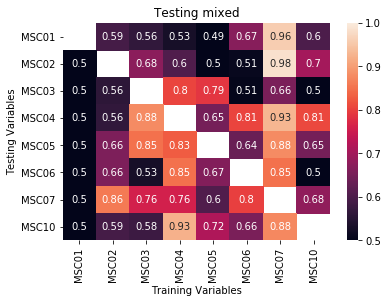

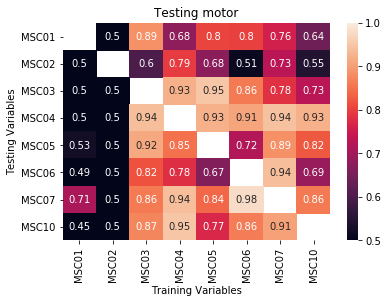

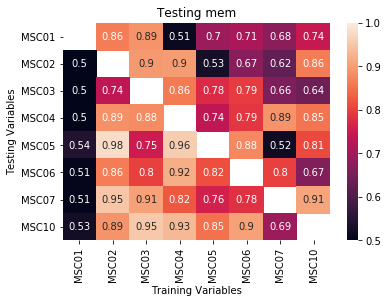

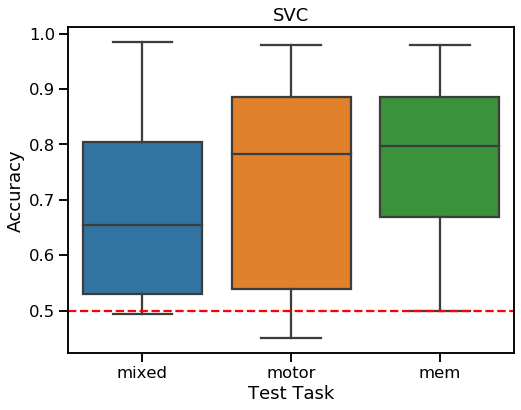

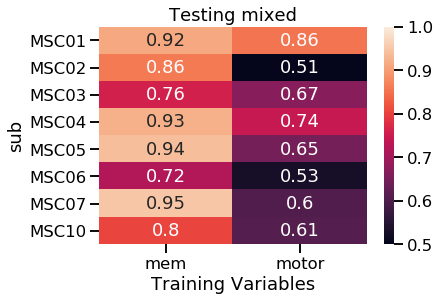

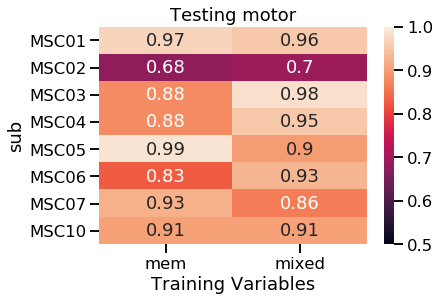

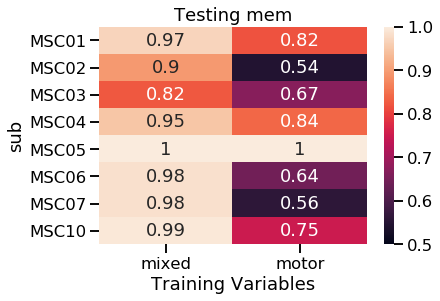

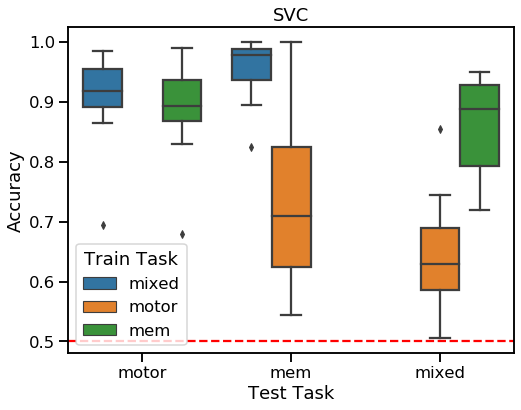

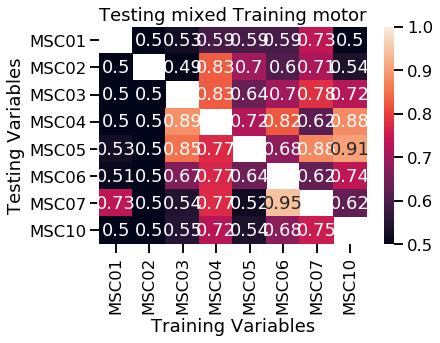

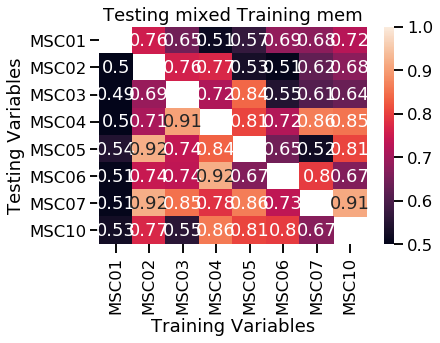

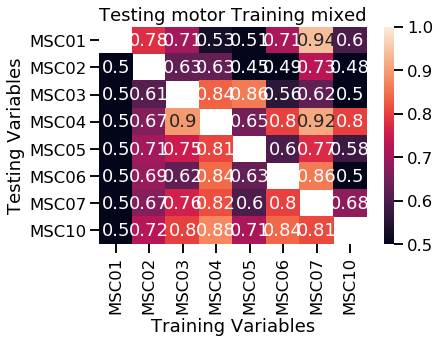

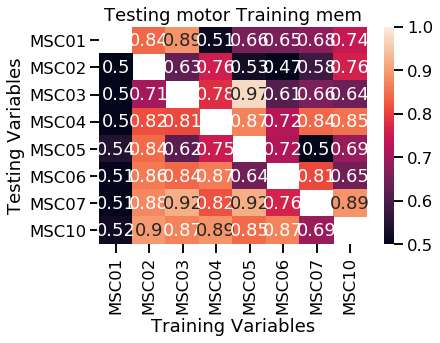

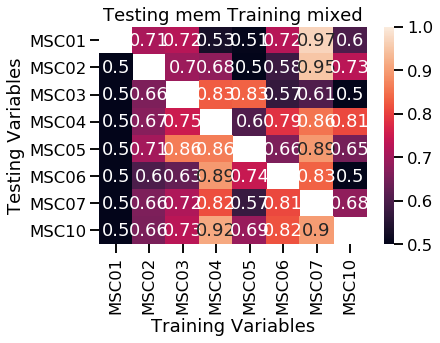

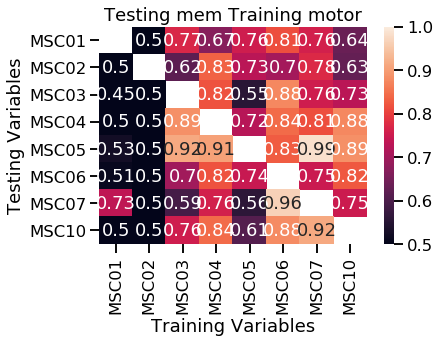

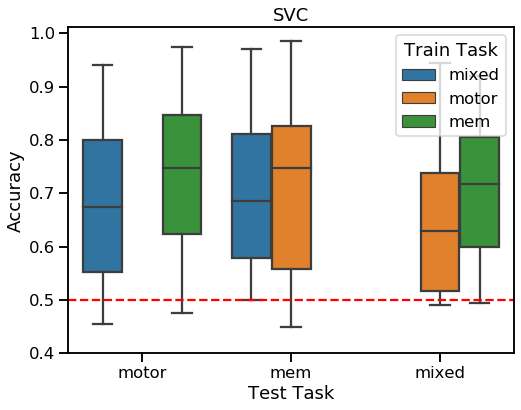

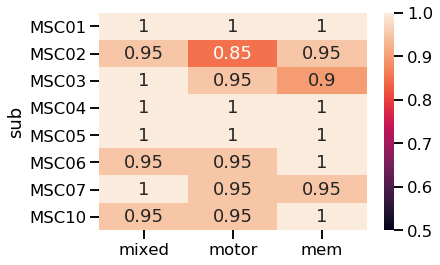

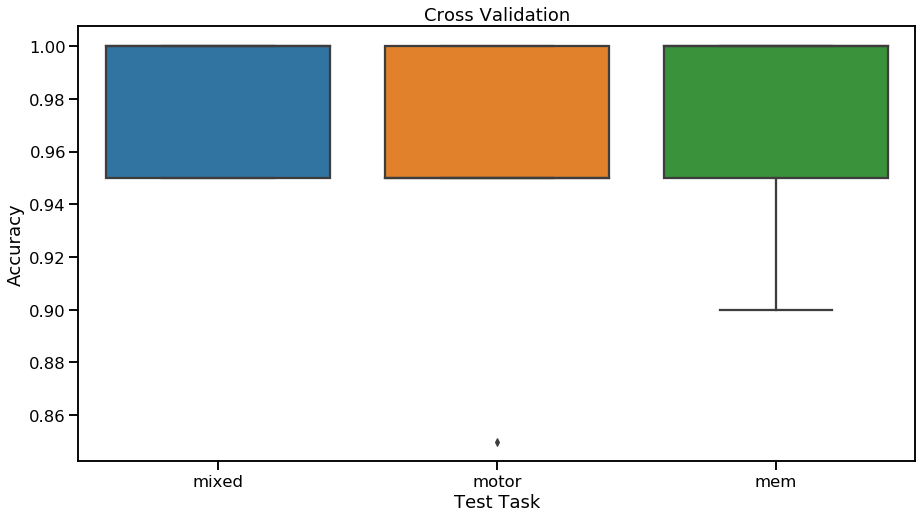

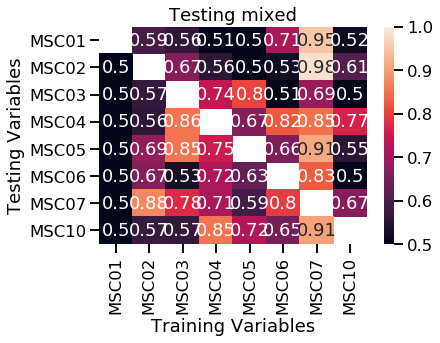

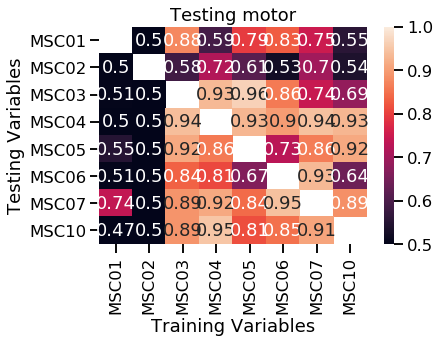

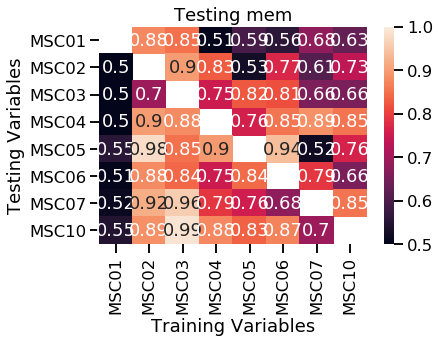

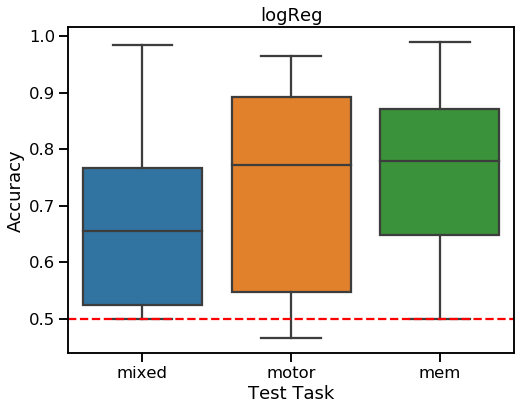

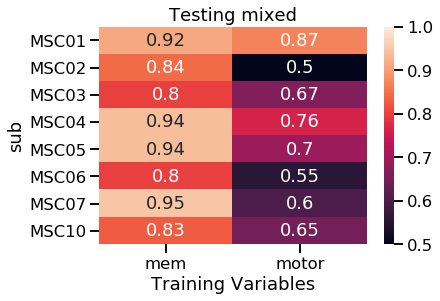

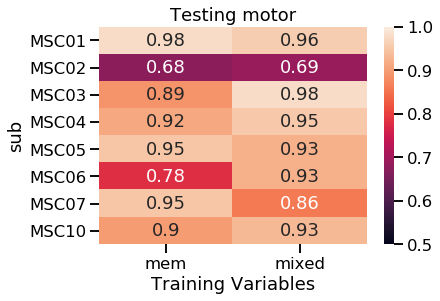

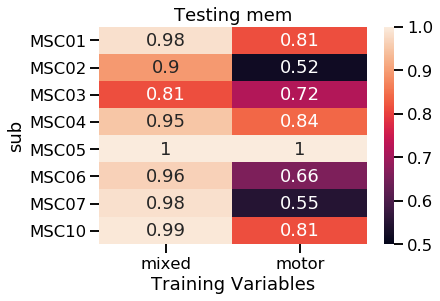

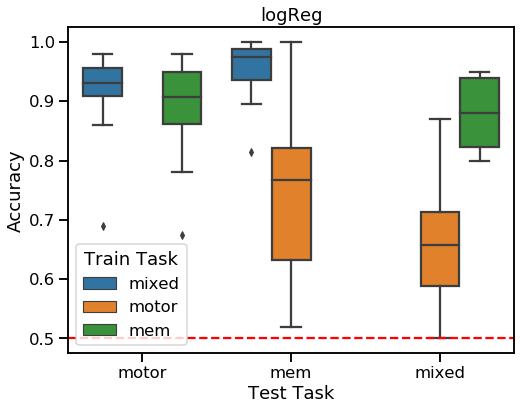

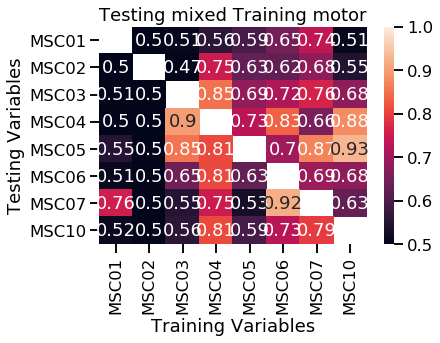

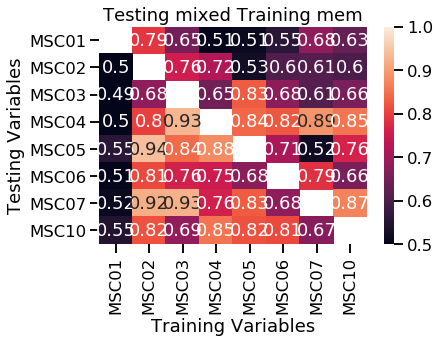

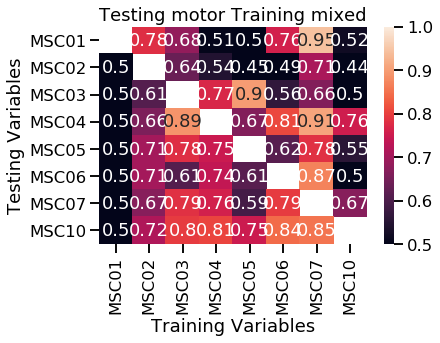

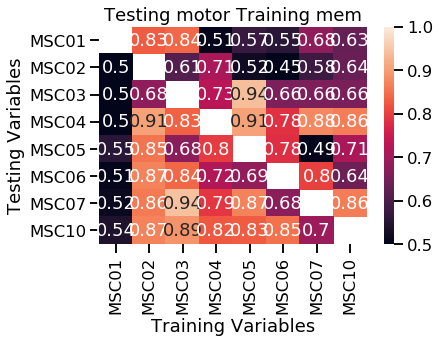

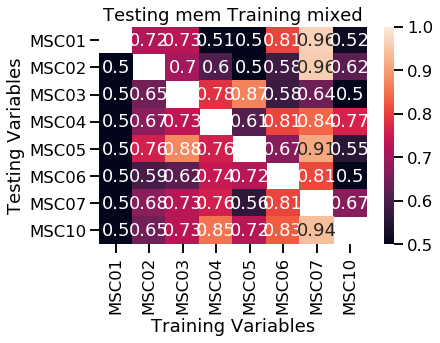

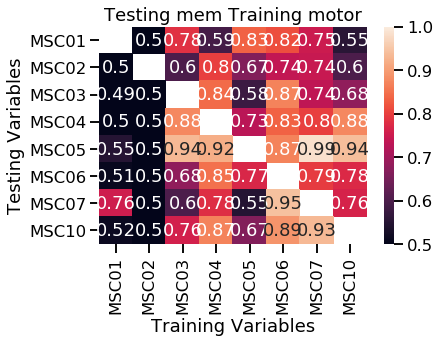

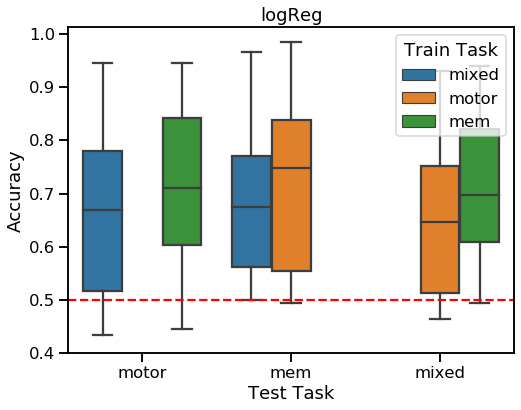

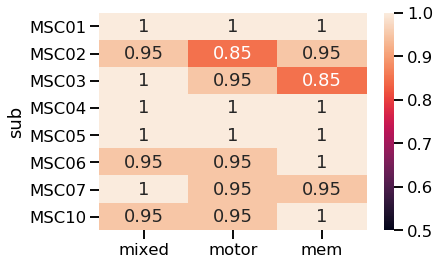

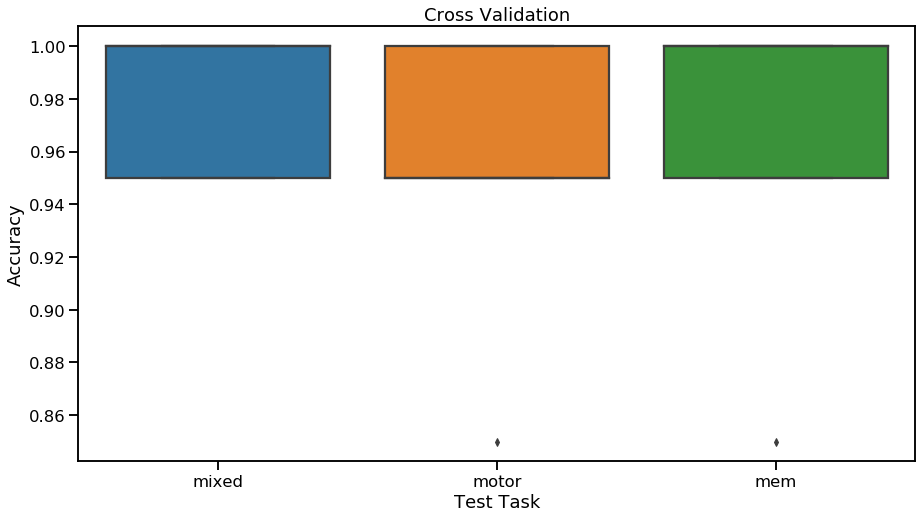

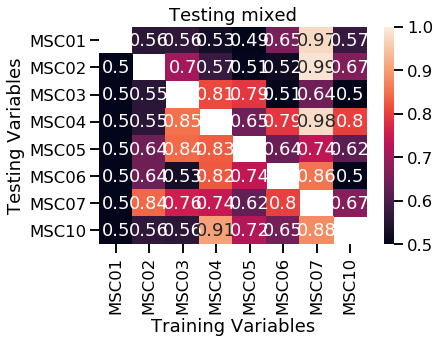

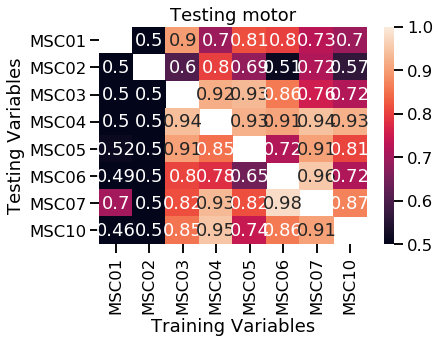

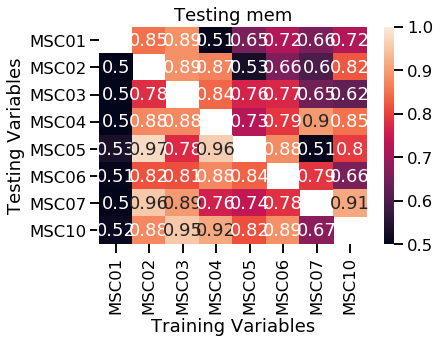

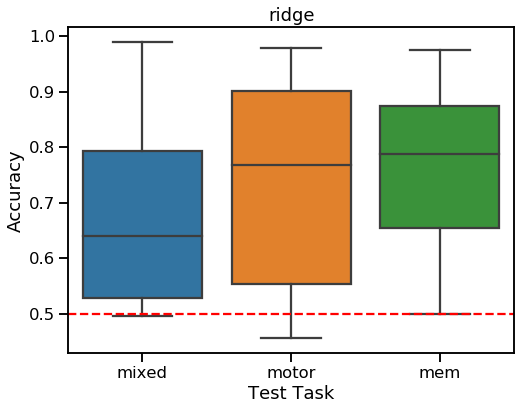

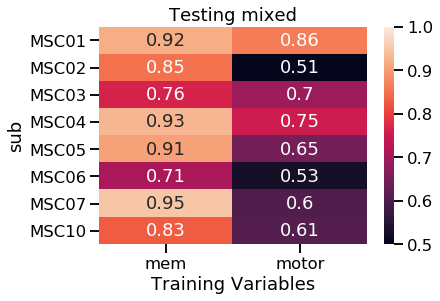

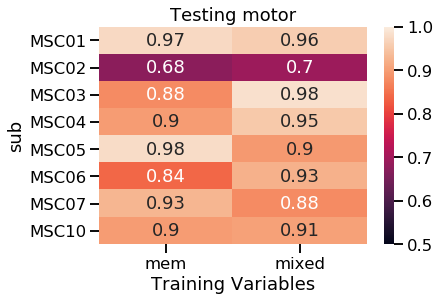

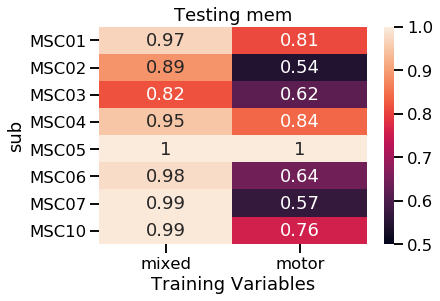

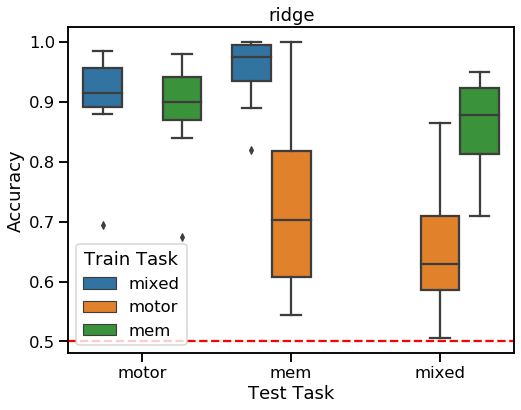

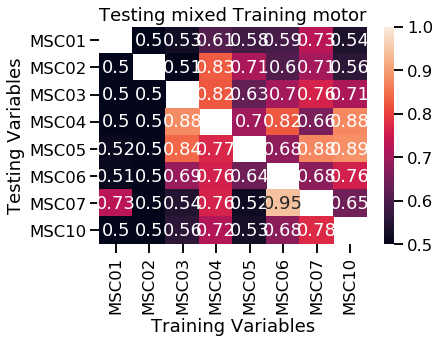

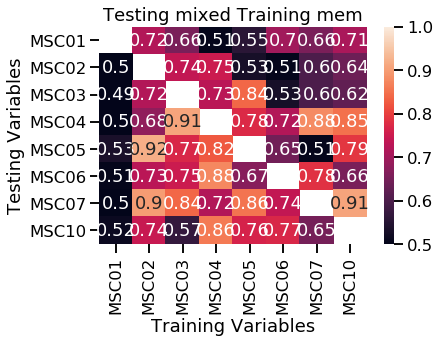

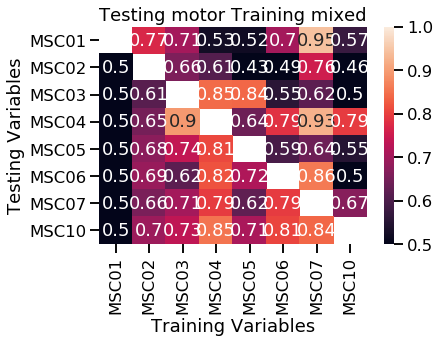

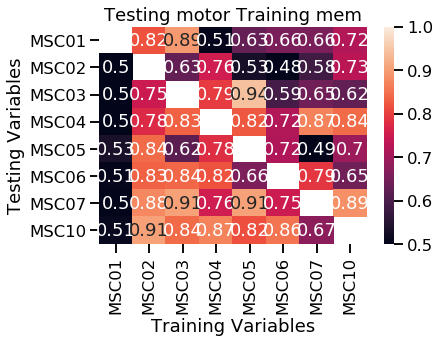

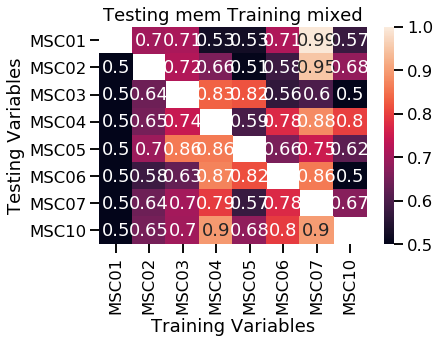

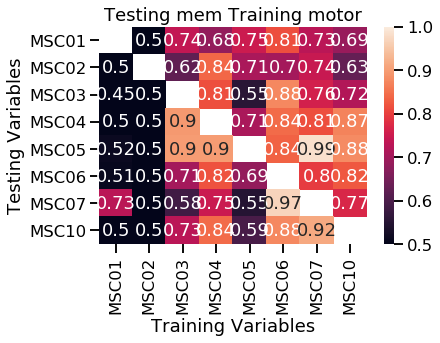

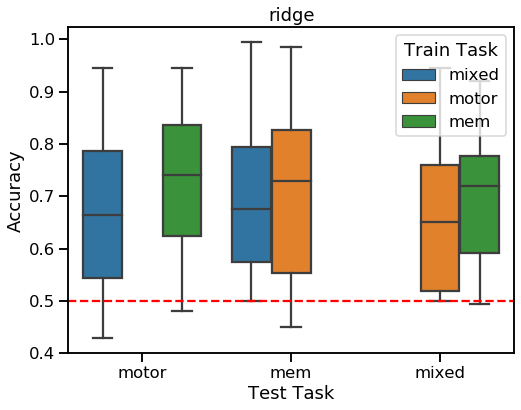

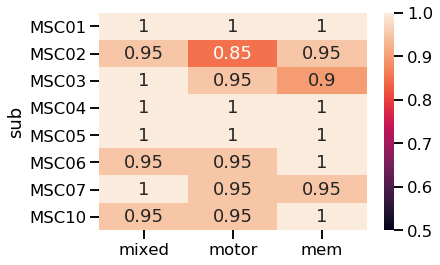

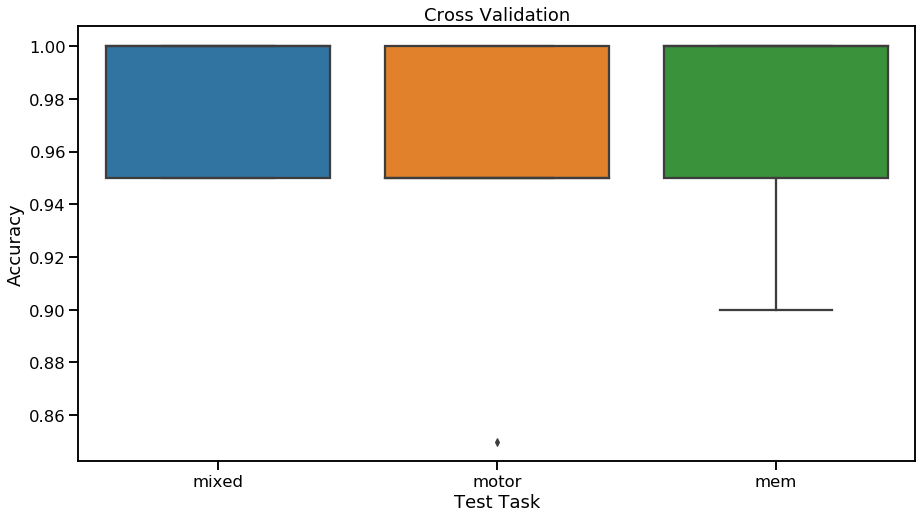

In [2]:
analysisList=['DS', 'SS', 'BS','CV']
classifierList=['SVC', 'logReg','ridge']
for classifier in classifierList:
    for analysis in analysisList:
        print('Now running '+classifier+' with analysis type '+analysis)
        run_prediction(classifier, analysis)


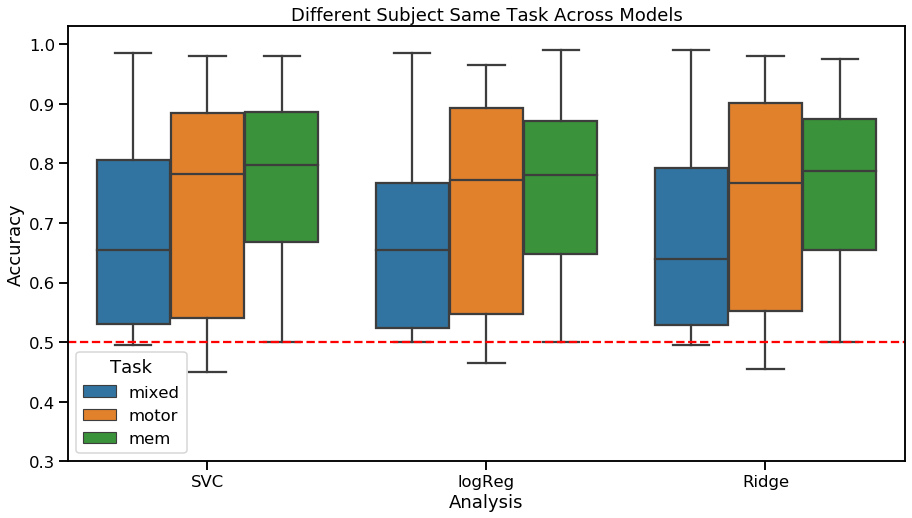

In [1]:
import results
results.ds_boxplot()
#results.bs_boxplot()
#results.ss_boxplot()
#results.cv_modelComp()